In [1]:
import os
import time
import torch

import numpy as np
import pandas as pd
from pathlib import Path

from fastai.vision.all import *
import timm

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from xrkit.utilities.seed import seed_everything
from xrkit.base import CONFIG
from xrkit.models import *
from xrkit.data.dataset import NIHDataset
from torch.utils.data import DataLoader

import pytorch_lightning as L
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from sklearn.metrics import f1_score as skf1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

from torchmetrics.classification import ROC
from torchmetrics.functional import accuracy, auroc, f1_score

os.chdir("..")
sns.set_theme()
torch.set_float32_matmul_precision("high")

In [2]:
SEED = 34
seed_everything(SEED)

In [3]:
data_path = Path(CONFIG.data.chestxray2017_classification.raw_path)

train_path = Path(data_path, "train")
validation_path = Path(data_path, "val")
test_path = Path(data_path, "test")

In [4]:
normal_cases_path = Path(train_path, "NORMAL")
pneumonia_cases_path = Path(train_path, "PNEUMONIA")

normal_cases = normal_cases_path.glob("*.jpeg")
pneumonia_cases = pneumonia_cases_path.glob("*.jpeg")

train_data = []

for image_path in normal_cases:
    train_data.append((image_path, 0))

for image_path in pneumonia_cases:
    train_data.append((image_path, 1))

train_data = pd.DataFrame(train_data, columns=["image", "label"], index=None)
train_data = train_data.sample(frac=1).reset_index(drop=True)

print(train_data.shape)
train_data.head()

(5216, 2)


,image,label
0,data/raw/chest_xray/train/PNEUMONIA/person1433_bacteria_3701.jpeg,1
1,data/raw/chest_xray/train/PNEUMONIA/person440_virus_893.jpeg,1
2,data/raw/chest_xray/train/PNEUMONIA/person881_virus_1531.jpeg,1
3,data/raw/chest_xray/train/PNEUMONIA/person1204_bacteria_3156.jpeg,1
4,data/raw/chest_xray/train/NORMAL/IM-0469-0001.jpeg,0


In [5]:
normal_cases_path = Path(validation_path, "NORMAL")
pneumonia_cases_path = Path(validation_path, "PNEUMONIA")

normal_cases = normal_cases_path.glob("*.jpeg")
pneumonia_cases = pneumonia_cases_path.glob("*.jpeg")

validation_data = []

for image_path in normal_cases:
    validation_data.append((image_path, 0))

for image_path in pneumonia_cases:
    validation_data.append((image_path, 1))

validation_data = pd.DataFrame(validation_data, columns=["image", "label"], index=None)
validation_data = validation_data.sample(frac=1).reset_index(drop=True)

print(validation_data.shape)
validation_data.head()

(16, 2)


,image,label
0,data/raw/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg,0
1,data/raw/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg,1
2,data/raw/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg,1
3,data/raw/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg,1
4,data/raw/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg,0


In [6]:
normal_cases_path = Path(test_path, "NORMAL")
pneumonia_cases_path = Path(test_path, "PNEUMONIA")

normal_cases = normal_cases_path.glob("*.jpeg")
pneumonia_cases = pneumonia_cases_path.glob("*.jpeg")

test_data = []

for image_path in normal_cases:
    test_data.append((image_path, 0))

for image_path in pneumonia_cases:
    test_data.append((image_path, 1))

test_data = pd.DataFrame(test_data, columns=["image", "label"], index=None)
test_data = test_data.sample(frac=1).reset_index(drop=True)

print(test_data.shape)
test_data.head()

(624, 2)


,image,label
0,data/raw/chest_xray/test/PNEUMONIA/person134_bacteria_640.jpeg,1
1,data/raw/chest_xray/test/NORMAL/NORMAL2-IM-0283-0001.jpeg,0
2,data/raw/chest_xray/test/NORMAL/NORMAL2-IM-0207-0001.jpeg,0
3,data/raw/chest_xray/test/PNEUMONIA/person1661_virus_2872.jpeg,1
4,data/raw/chest_xray/test/NORMAL/NORMAL2-IM-0290-0001.jpeg,0


In [7]:
train_validation_data = pd.concat([train_data, validation_data]).reset_index(drop=True)
validation_indices = train_validation_data[-len(validation_data) :].index.tolist()

print(train_validation_data.shape)
train_validation_data.head()

(5232, 2)


,image,label
0,data/raw/chest_xray/train/PNEUMONIA/person1433_bacteria_3701.jpeg,1
1,data/raw/chest_xray/train/PNEUMONIA/person440_virus_893.jpeg,1
2,data/raw/chest_xray/train/PNEUMONIA/person881_virus_1531.jpeg,1
3,data/raw/chest_xray/train/PNEUMONIA/person1204_bacteria_3156.jpeg,1
4,data/raw/chest_xray/train/NORMAL/IM-0469-0001.jpeg,0


In [8]:
item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    return row["image"]


def get_y(row):
    return row["label"]


train_validation_data_block = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=["Pneumonia"])),
    splitter=IndexSplitter(validation_indices),
    get_x=get_x,
    get_y=get_y,
    item_tfms=item_transforms,
    batch_tfms=batch_transforms,
)

train_validation_dataloader = train_validation_data_block.dataloaders(
    train_validation_data, bs=CONFIG.base.batch_size
)

test_data_block = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=["Pneumonia"])),
    splitter=RandomSplitter(valid_pct=0, seed=SEED),
    get_x=get_x,
    get_y=get_y,
    item_tfms=item_transforms,
    batch_tfms=batch_transforms,
)

test_dataloader = test_data_block.dataloaders(test_data, bs=CONFIG.base.batch_size)

In [9]:
callbacks = [
    SaveModelCallback(monitor="valid_loss", min_delta=0.0001, with_opt=True),
    EarlyStoppingCallback(monitor="valid_loss", min_delta=0.0001, patience=10),
    ShowGraphCallback(),
]

network = "mobilenetv2_100"

learn = vision_learner(
    train_validation_dataloader,
    network,
    pretrained=True,
    metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],
    cbs=callbacks,
    wd=0.1,
)

learn.model = torch.nn.DataParallel(learn.model)

Initial Learning Rate: 0.00363078061491251


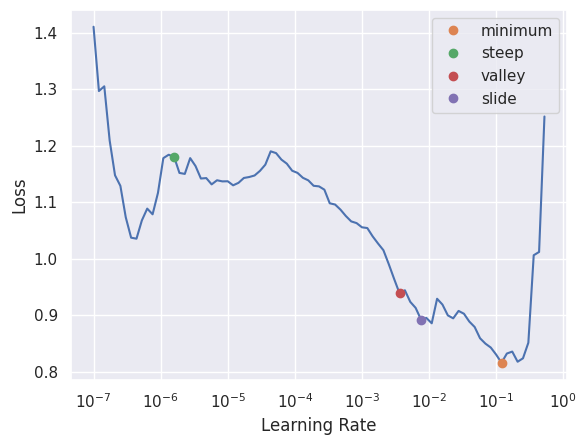

In [10]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print("Initial Learning Rate:", lrs.valley)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.326491,0.374332,0.812500,0.805668,0.937500,00:21
1,0.298691,0.656353,0.687500,0.653680,0.921875,00:22
2,0.227016,0.621285,0.750000,0.733333,0.843750,00:20
3,0.203359,0.924192,0.625000,0.563636,0.750000,00:20
4,0.163558,0.628265,0.687500,0.653680,0.953125,00:20
5,0.169055,0.173225,0.937500,0.937255,1.000000,00:20
6,0.212107,0.761445,0.750000,0.733333,0.890625,00:20
7,0.148230,0.597500,0.812500,0.805668,0.921875,00:20
8,0.122368,0.386507,0.937500,0.937255,0.968750,00:21
9,0.140192,0.232634,0.937500,0.937255,0.968750,00:20


Better model found at epoch 0 with valid_loss value: 0.37433162331581116.


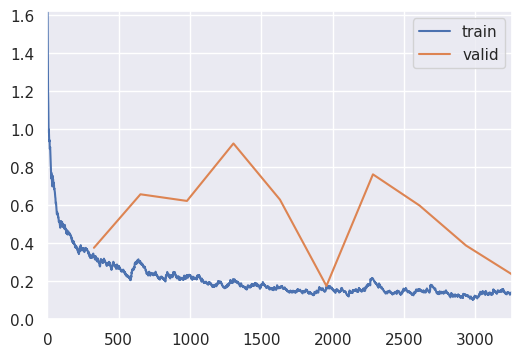

Better model found at epoch 5 with valid_loss value: 0.1732247769832611.


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.117134,0.752768,0.625000,0.563636,0.984375,00:24
1,0.115530,0.407396,0.687500,0.653680,1.000000,00:24
2,0.102689,0.566345,0.687500,0.653680,0.984375,00:24
3,0.098677,0.601473,0.625000,0.563636,0.968750,00:24
4,0.099138,0.606939,0.812500,0.805668,0.937500,00:24
5,0.095279,0.406286,0.812500,0.805668,1.000000,00:25
6,0.080427,0.493132,0.812500,0.805668,0.937500,00:24
7,0.075016,0.510662,0.875000,0.873016,0.953125,00:24
8,0.081960,0.776224,0.562500,0.458937,0.984375,00:24
9,0.092942,0.543950,0.812500,0.805668,0.937500,00:24


Better model found at epoch 0 with valid_loss value: 0.7527677416801453.


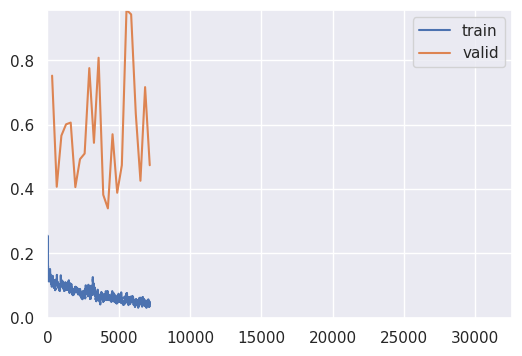

Better model found at epoch 1 with valid_loss value: 0.407395601272583.
Better model found at epoch 5 with valid_loss value: 0.4062855839729309.
Better model found at epoch 11 with valid_loss value: 0.3824574053287506.
Better model found at epoch 12 with valid_loss value: 0.34014463424682617.
No improvement since epoch 12: early stopping


In [11]:
n_epochs = 100

start_training_time = time.time()
learn.fine_tune(freeze_epochs=10, epochs=n_epochs, base_lr=lrs.valley)
end_training_time = time.time()

In [12]:
learn.save("mobilenetv2tl")

Path('models/mobilenetv2tl.pth')

In [13]:
learner = vision_learner(test_dataloader, network, metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()])
learner.model = torch.nn.DataParallel(learner.model)

learner.load("mobilenetv2tl")
learner.to("cuda")

learner.freeze()

start_testing_time = time.time()
predictions, targets = learner.get_preds(ds_idx=0)
end_testing_time = time.time()

In [14]:
kwargs = {"preds": predictions[:, 0], "target": targets.int(), "task": "binary"}

In [15]:
print(f"Tempo de treinamento: {(end_training_time - start_training_time):.1f} segundos")
print(f"Tempo de teste: {(end_testing_time - start_testing_time) / 4:.1f} segundos")

Tempo de treinamento: 790.2 segundos
Tempo de teste: 0.7 segundos


In [16]:
print(
    classification_report(
        kwargs["target"], kwargs["preds"] > 0.5, target_names=["Normal", "Pneumonia"], digits=4
    )
)

              precision    recall  f1-score   support

      Normal     0.9673    0.6325    0.7649       234
   Pneumonia     0.8174    0.9872    0.8943       390

    accuracy                         0.8542       624
   macro avg     0.8924    0.8098    0.8296       624
weighted avg     0.8736    0.8542    0.8458       624



In [17]:
print("Global F1 Score:", np.round(f1_score(**kwargs, average="macro").item(), 3))
print(
    "Class F1 Score:", np.round(skf1_score(kwargs["target"], kwargs["preds"] > 0.5, average=None).tolist(), 3)
)
print("Global Accuracy:", np.round(accuracy(**kwargs, average="macro").item(), 3))
print("Global AUROC:", np.round(auroc(**kwargs, average="macro").item(), 3))

Global F1 Score: 0.894
Class F1 Score: [0.765 0.894]
Global Accuracy: 0.854
Global AUROC: 0.941


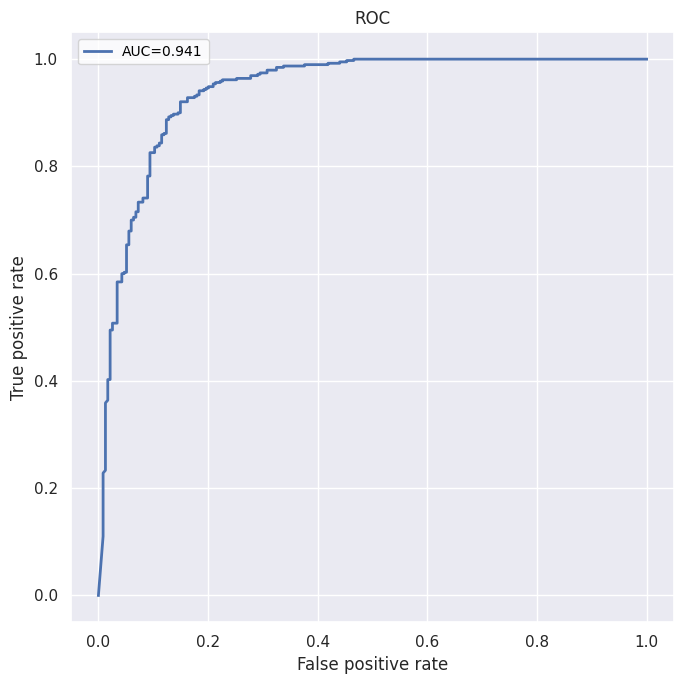

In [18]:
roc = ROC(task="binary")
roc(kwargs["preds"], kwargs["target"])
_, axis = plt.subplots(figsize=(7, 7))
roc.plot(score=True, ax=axis)
handles, current_labels = axis.get_legend_handles_labels()

plt.title("ROC")

plt.tight_layout()
plt.show()

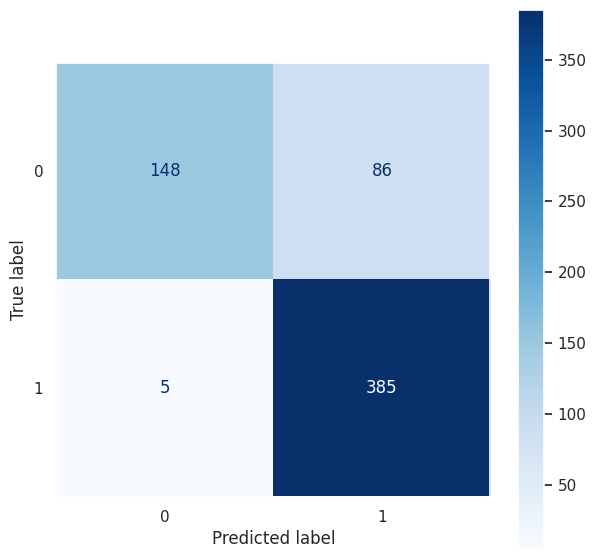

In [19]:
_, axes = plt.subplots(figsize=(7, 7))

disp = ConfusionMatrixDisplay(confusion_matrix(kwargs["target"], kwargs["preds"] > 0.5))
disp.plot(ax=axes, cmap="Blues")

plt.grid(False)

plt.show()